# Preprocessing

From EDA, we understood that:
- We have duplicated rows on customer_basket
- When the same items are bought in two different instances, these are attributed different invoices. Hence, invoice_id cannot be the index column
- 32% have a missing loyalty_card_number (probably don't have one)
- percentage_of_products_bought_promotion is a percentage with negative values
#
From EDA, we also noted that there are no really highly correlated values, hence nothing should be dropped.

In [33]:
import numpy as np
import pandas as pd
from datetime import datetime # to get the current datetime

import matplotlib.pyplot as plt # to make plots (histograms, etc...)
import seaborn as sns
import plotly.express as px
import folium
import branca.colormap as cm  # for color mapping based on data values

import ast # transform the strings into a list

from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator # to automatically find the "knee" for the dbscan's parameter
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [5]:
# Show all columns when displaying a DataFrame
pd.set_option('display.max_columns', None)

# Optional: Also show more rows if needed
pd.set_option('display.max_rows', 100)

# shows all columns
pd.set_option("display.max_columns", None)

# prevents wrapping
pd.set_option("display.width", 1000)

pd.set_option('display.max_colwidth', None)

### 1. Import and Preview Datasets ###

In [6]:
customer_basket = pd.read_csv('../data/raw/customer_basket.csv')
customer_info = pd.read_csv('../data/raw/customer_info.csv', index_col=["customer_id"])

customer_info = customer_info.drop("Unnamed: 0", axis='columns')

In [7]:
customer_basket.head(5)

,invoice_id,list_of_goods,customer_id
0,5062209,"['megaman zero 3', 'energy bar', 'pokemon violet', 'airpods', 'fresh bread', 'pancakes', 'brownies', 'energy drink', 'champagne', 'red wine', 'bluetooth headphones', 'protein bar', 'metroid fusion']",4925
1,4272512,"['black beer', 'bramble', 'laptop', 'pokemon violet', 'airpods', 'gadget for tiktok streaming', 'ring light', 'ratchet & clank', 'pancakes', 'energy drink', 'gums', 'protein bar']",19046
2,7121052,"['soup', 'shallot', 'cake', 'fresh bread', 'cream', 'carrots', 'babies food', 'ham', 'cookies', 'salad', 'tomato sauce', 'cooking oil', 'tea']",10318
3,5847748,"['soup', 'cooking oil', 'cereals', 'oil', 'dog food', 'deodorant', 'tomatoes', 'yogurt cake', 'pet food', 'salmon', 'olive oil', 'fresh tuna', 'tea']",27283
4,6336114,"['eggplant', 'mint green tea', 'oil', 'bacon', 'toilet paper', 'shrimp', 'brownies', 'pancakes', 'champagne', 'spinach', 'cologne', 'chicken', 'barbecue sauce', 'fresh tuna']",16072


In [8]:
customer_info.head(5)

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,,,,
29930,April Clark,female,01/15/1972 02:27 PM,2.0,2.0,1.0,4.0,7789.0,5601.0,13.0,726.0,962.0,1213.0,1598.0,1894.0,457.0,412.0,428.0,386.0,0.158741,2018.0,NaN,38.721807,-9.125534
6813,Bsc. Paul Ketchum,male,07/31/1944 10:53 AM,0.0,1.0,0.0,4.0,8653.0,35.0,14.0,792.0,102.0,104.0,741.0,346.0,394.0,75.0,226.0,73.0,1.227890,2013.0,971840.0,38.734668,-9.163533
39451,Mary Downing,female,11/13/1989 02:11 PM,2.0,3.0,0.0,7.0,15605.0,4275.0,14.0,1585.0,980.0,1872.0,1323.0,1971.0,920.0,335.0,192.0,319.0,0.101598,2011.0,NaN,38.787126,-9.147077
21557,Manuel Kueny,male,08/09/1976 06:23 AM,0.0,0.0,1.0,1.0,13440.0,16366.0,14.0,28.0,269.0,1855.0,939.0,785.0,139.0,679.0,270.0,221.0,0.259943,2009.0,NaN,38.741816,-9.159700
16415,Phd. Curtis Tharp,male,07/11/1966 08:12 AM,1.0,1.0,1.0,5.0,49250.0,3197.0,14.0,258.0,726.0,547.0,983.0,1492.0,1046.0,112.0,144.0,244.0,0.317822,2012.0,925367.0,38.785921,-9.149221


In [9]:
customer_basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   invoice_id     100000 non-null  int64 
 1   list_of_goods  100000 non-null  object
 2   customer_id    100000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [10]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34060 entries, 29930 to 22050
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_name                            34060 non-null  object 
 1   customer_gender                          34060 non-null  object 
 2   customer_birthdate                       33719 non-null  object 
 3   kids_home                                33311 non-null  float64
 4   teens_home                               33277 non-null  float64
 5   number_complaints                        33038 non-null  float64
 6   distinct_stores_visited                  33379 non-null  float64
 7   lifetime_spend_groceries                 34060 non-null  float64
 8   lifetime_spend_electronics               34060 non-null  float64
 9   typical_hour                             32698 non-null  float64
 10  lifetime_spend_vegetables                33038 

Because the datasets are rather small and mostly numerical, we don't see the need to adapt the data types 

### 2. Feature Selection (Part 1)

#### 2.1) Adding an *age* column

##### 2.1.1) Altering the customer_birthdate column to datetime format

In [11]:
customer_info["customer_birthdate"] = pd.to_datetime(customer_info["customer_birthdate"], format="%m/%d/%Y %I:%M %p")

##### 2.1.2) Creating the age column throught the differece between the current date and the birth date

In [12]:
today = datetime.now()
customer_info["age"] = customer_info["customer_birthdate"].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day))) # works because True = 1 and False = 0

#### 2.2) Removing features

In [13]:
customer_info.head()

,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,age
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,
29930,April Clark,female,1972-01-15 14:27:00,2.0,2.0,1.0,4.0,7789.0,5601.0,13.0,726.0,962.0,1213.0,1598.0,1894.0,457.0,412.0,428.0,386.0,0.158741,2018.0,NaN,38.721807,-9.125534,53.0
6813,Bsc. Paul Ketchum,male,1944-07-31 10:53:00,0.0,1.0,0.0,4.0,8653.0,35.0,14.0,792.0,102.0,104.0,741.0,346.0,394.0,75.0,226.0,73.0,1.227890,2013.0,971840.0,38.734668,-9.163533,80.0
39451,Mary Downing,female,1989-11-13 14:11:00,2.0,3.0,0.0,7.0,15605.0,4275.0,14.0,1585.0,980.0,1872.0,1323.0,1971.0,920.0,335.0,192.0,319.0,0.101598,2011.0,NaN,38.787126,-9.147077,35.0
21557,Manuel Kueny,male,1976-08-09 06:23:00,0.0,0.0,1.0,1.0,13440.0,16366.0,14.0,28.0,269.0,1855.0,939.0,785.0,139.0,679.0,270.0,221.0,0.259943,2009.0,NaN,38.741816,-9.159700,48.0
16415,Phd. Curtis Tharp,male,1966-07-11 08:12:00,1.0,1.0,1.0,5.0,49250.0,3197.0,14.0,258.0,726.0,547.0,983.0,1492.0,1046.0,112.0,144.0,244.0,0.317822,2012.0,925367.0,38.785921,-9.149221,58.0


Columns to remove:
- *customer_name* - Since customers are already identified by id, there's no need to save their name;
- *customer_birthdate* - Due to the fact that we've already created an *age* column;
- *year_first_transaction* - We believe the worth this variable has is already in the *age* column, given the relation that the older people are, the smaller will be the year of the first transation, and no additional value may be extrated;
- *loyalty_card_number* - This is a set of digits with no meaning, assigned to customers with loyalty cards. Its only possible purpose would be distinguishing in between customers since the numbers are theoretically unique for each one. However, not all customers have a loyalty card and we already have the *customer_id* column, so this variable has no worth.
- *latitude* and *longitude* - these two columns are only used for the map made in the EDA, which showed no visible pattern.

In [14]:
customer_info = customer_info.drop(["customer_name", "customer_birthdate", "year_first_transaction", "loyalty_card_number", "latitude", "longitude"], axis=1)

#### 2.3) Assessing highly correlated features

Sometimes, variables present correlations that justfy removing one of them, as it becomes redundant to keep both. As we saw through our heatmap, some features do have a rather high correlation. However, we don't consider these nearly enough to remove them.

#### 2.4) Label encoding for the *customer_gender* variable

In [15]:
customer_info["customer_gender"] = np.where(customer_info["customer_gender"] == "female", 0, 1)

### 3. Unidimensional Outlier Detection

### 4. Scaling
We'll be using Robust Scaler to scale our data as it has shown, through the EDA's boxplots and histograms, a high presence of outliers

In [16]:
scaler = RobustScaler()

scaled_array = scaler.fit_transform(customer_info)
scaled_customer_info = pd.DataFrame(scaled_array, columns=customer_info.columns, index=customer_info.index)
customer_info = scaled_customer_info

### 5. Data Cleaning ###
Dealing with the duplicates, missing values and noise

#### 5.1) Duplicates

##### 5.1.1) For customer_basket

In [17]:
customer_basket.duplicated().sum()

np.int64(0)

On a first look, it seems there are no duplicated rows...

In [18]:
customer_basket["invoice_id"].is_unique

False

In [19]:
customer_basket["customer_id"].is_unique

False

With this, we may conclude that, although there are no duplicated rows, some refer to the same customer making different purchases (identical *customer_id*), while others reflect different customers buying the same set of items (identical *invoice_id*).

##### 5.1.2) For customer_info

In [20]:
customer_basket.duplicated().sum()

np.int64(0)

Here, because we managed to set *customer_id* as an index, and also due to the last block of code showing no repeated rows, we may conclude there aren't any duplicates in the *customer_info* dataset

#### 5.2) Missing Values / Imputation

##### 5.2.1) For customer_basket

In [21]:
missing_customer_basket = pd.DataFrame({
    'Missing Count': customer_basket.isnull().sum(),
    'Missing %': round(customer_basket.isnull().mean() * 100, 2)
})
missing_customer_basket

,Missing Count,Missing %
invoice_id,0,0.0
list_of_goods,0,0.0
customer_id,0,0.0


Great! We have no missing values in the *customer_basket* dataset.

##### 5.2.2) For customer_info

In [22]:
missing_customer_info = pd.DataFrame({
    'Missing Count': customer_info.isnull().sum(),
    'Missing %': round(customer_info.isnull().mean() * 100, 2)
})
missing_customer_info

,Missing Count,Missing %
customer_gender,0,0.0
kids_home,749,2.2
teens_home,783,2.3
number_complaints,1022,3.0
distinct_stores_visited,681,2.0
lifetime_spend_groceries,0,0.0
lifetime_spend_electronics,0,0.0
typical_hour,1362,4.0
lifetime_spend_vegetables,1022,3.0
lifetime_spend_nonalcohol_drinks,0,0.0


We will use K Nearest Neighbours imputation to replace these missing values. Firstly, we need to find a value for K.

To evaluate the optimal number of neighbours for KNN imputation, we selected rows where the 'age' variable was not missing and split the data into training and test sets. In the test set, we artificially removed the 'age' values to simulate missingness while keeping the true values for comparison. We then applied KNN imputation with different values of k to the combined dataset and measured the accuracy of the imputed values by calculating the RMSE against the original 'age' values in the test set. This allowed us to identify which k produced the most accurate imputations.

In [23]:
# keep only the rows where 'age' is observed
complete_data = customer_info[customer_info['age'].notna()].copy()

train_set, test_set = train_test_split(complete_data, test_size=0.2, random_state=42)

# storing the true values to compare later
true_age = test_set['age'].copy()

# artificially set "age" to NaN in test set to simulate missingness
test_set.loc[:, 'age'] = np.nan

simulated_data = pd.concat([train_set, test_set])

rmse_per_k = {}

for k in [5, 10, 15]:
    imputer = KNNImputer(n_neighbors=k)
    imputed_array = imputer.fit_transform(simulated_data.select_dtypes(include='number'))
    imputed_df = pd.DataFrame(imputed_array, columns=simulated_data.select_dtypes(include='number').columns)

    imputed_df.index = simulated_data.index
    
    # Recover imputed values for the previously missing 'age' in test_set
    imputed_age = imputed_df.loc[test_set.index, 'age']
    
    rmse = np.sqrt(mean_squared_error(true_age, imputed_age))
    rmse_per_k[k] = rmse

print("RMSE for each K:", rmse_per_k)


RMSE for each K: {5: np.float64(0.564048453033348), 10: np.float64(0.540679705226091), 15: np.float64(0.5334008014589632)}


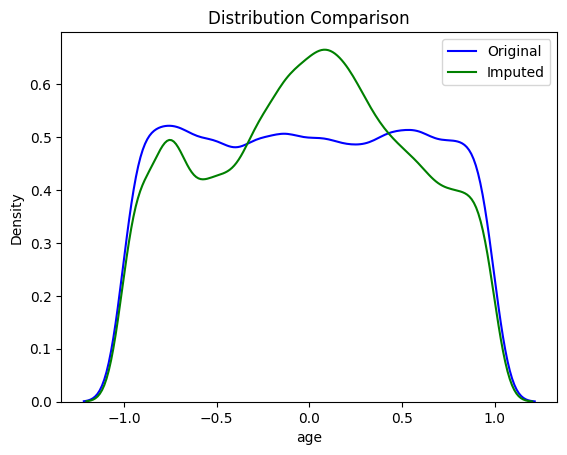

In [24]:
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(simulated_data.select_dtypes(include='number'))
imputed_df = pd.DataFrame(imputed_array, columns=simulated_data.select_dtypes(include='number').columns)

# Compare original vs imputed
sns.kdeplot(customer_info['age'], label='Original', color='blue')
sns.kdeplot(imputed_df['age'], label='Imputed', color='green')
plt.legend()
plt.title('Distribution Comparison')
plt.show()


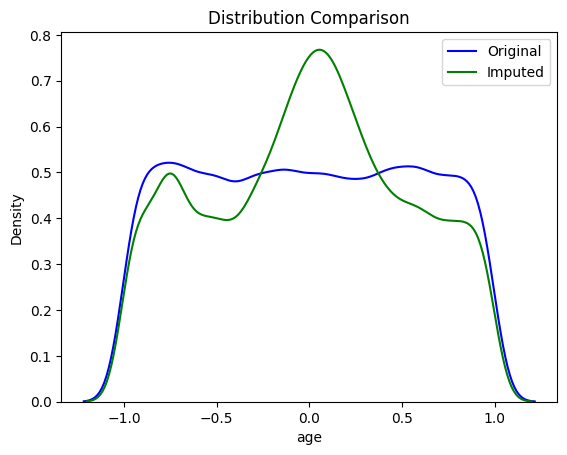

In [25]:
imputer = KNNImputer(n_neighbors=10)
imputed_array = imputer.fit_transform(simulated_data.select_dtypes(include='number'))
imputed_df = pd.DataFrame(imputed_array, columns=simulated_data.select_dtypes(include='number').columns)

# Compare original vs imputed
sns.kdeplot(customer_info['age'], label='Original', color='blue')
sns.kdeplot(imputed_df['age'], label='Imputed', color='green')
plt.legend()
plt.title('Distribution Comparison')
plt.show()


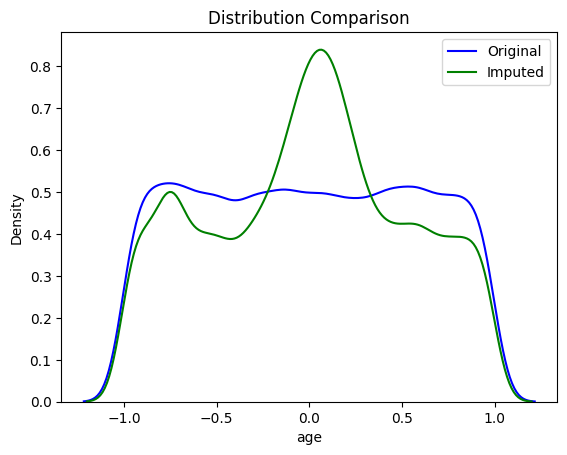

In [26]:
imputer = KNNImputer(n_neighbors=15)
imputed_array = imputer.fit_transform(simulated_data.select_dtypes(include='number'))
imputed_df = pd.DataFrame(imputed_array, columns=simulated_data.select_dtypes(include='number').columns)

# Compare original vs imputed
sns.kdeplot(customer_info['age'], label='Original', color='blue')
sns.kdeplot(imputed_df['age'], label='Imputed', color='green')
plt.legend()
plt.title('Distribution Comparison')
plt.show()


Given these results, we chose k=10, as a larger k begins to show signs of underfitting due to the fact that there's a higher and higher number of predicted values in between the ages 50-60, which is where we have the median of *age* (as seen in the EDA)

In [27]:
imputer = KNNImputer(n_neighbors=10)
customer_info[:] = imputer.fit_transform(customer_info)

In [28]:
missing_customer_info = pd.DataFrame({
    'Missing Count': customer_info.isnull().sum(),
    'Missing %': round(customer_info.isnull().mean() * 100, 2)
})
missing_customer_info

,Missing Count,Missing %
customer_gender,0,0.0
kids_home,0,0.0
teens_home,0,0.0
number_complaints,0,0.0
distinct_stores_visited,0,0.0
lifetime_spend_groceries,0,0.0
lifetime_spend_electronics,0,0.0
typical_hour,0,0.0
lifetime_spend_vegetables,0,0.0
lifetime_spend_nonalcohol_drinks,0,0.0


#### 5.3) Noise

As we saw in the EDA, some values are impossible to achieve, namely negative numbers in <i>percentage_of_products_bought_promotion</i>. Thus, we will assume these values to be zero and replace them.

In [29]:
# replace the percentage_of_products_bought_promotion below 0 with 0

import numpy as np

customer_info["percentage_of_products_bought_promotion"] = np.where(
    customer_info["percentage_of_products_bought_promotion"] < 0,
    0,
    customer_info["percentage_of_products_bought_promotion"]
)

### 6. Outlier Detection
Using DBSCAN to determine the presence of multidimensional outliers; Analysing the presence of unidimensional outliers.

#### 6.1) Figuring out the parameters: min_samples
As a starting point, we will use the rule of thumb that the minimum number of points is equal to 1 + the number of features

In [30]:
min_samples_value = 1 + customer_info.shape[1]
min_samples_value

20

#### 6.2) Figuring out the parameters: eps
It works like being in a crowded room, with 300 people for instance. Now we want to know, for a person, how large is the radius of the circle we have to draw around them to get the k nearest people.
Once we have those 300 distances sorted and plotted, we will see that some, in denser clusters of people, will have very short distances, some will have medium distances, and some, in more sparse groups (or perhaps even outliers), will have larger distances. We then look for the "elbow" of the plotted graph.

Why do we want the "elbow" of the graph? In DBSCAN, the elbow of the k-distance graph shows the point where the distance between points suddenly increases, meaning we're moving from dense regions (clusters) to sparse regions (noise).

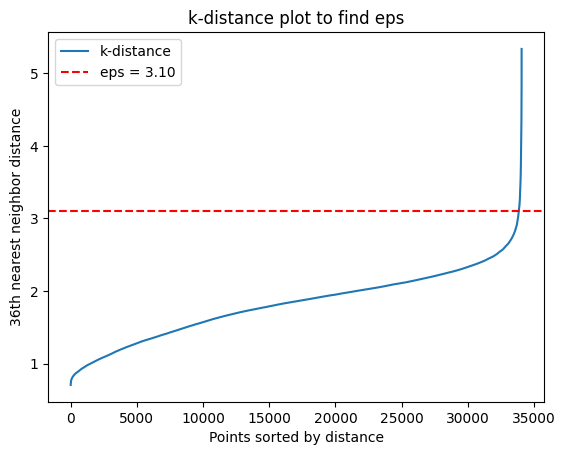

Suggested eps from knee point: 3.101


In [31]:
# compute distances to the 36th nearest neighbor
neighbors = NearestNeighbors(n_neighbors=36)
neighbors_fit = neighbors.fit(customer_info)
distances, _ = neighbors_fit.kneighbors(customer_info)

k_distances = np.sort(distances[:, 35])
x = np.arange(len(k_distances))

# using KneeLocator to find the elbow in the graph
knee = KneeLocator(x, k_distances, curve='convex', direction='increasing')
eps_value = k_distances[knee.knee]

# plotting the k-distance curve and the elbow
plt.plot(k_distances, label='k-distance')
plt.axhline(y=eps_value, color='red', linestyle='--', label=f'eps = {eps_value:.2f}')
plt.xlabel("Points sorted by distance")
plt.ylabel("36th nearest neighbor distance")
plt.title("k-distance plot to find eps")
plt.legend()
plt.show()

print(f"Suggested eps from knee point: {eps_value:.3f}")


#### 6.3) Running the DBSCAN

In [ ]:
print(eps_value, min_samples_value)

db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
db.fit(customer_info)

3.101036129027549 20
[0 0 0 ... 0 0 0]


In [40]:
labels = db.labels_ # -1 is noise, 0, 1, 2, ... are clusters

n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # number of clusters, excluding noise
n_outliers = list(labels).count(-1) # number of noise points
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of outliers: {n_outliers}")

Estimated number of clusters: 1
Estimated number of outliers: 17


It seems our dbscan was no very fruitful, so we'll adapt to a different strategy. Let's expand the range of attempts and combinations of eps and min_sample. We should aim for 3% outliers max.

In [50]:
three_percent = round((customer_info.shape[0]*3) / 100)
print(three_percent)

1022


In [51]:
for mp in range(10,101, 10):
    for eps_ in [1.7,1.9,2,2.2,2.5,3]:
        db = DBSCAN(eps=eps_, min_samples=mp)
        db.fit(customer_info)

        labels = db.labels_  # cluster labels, -1 = outlier

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)
        
        if n_outliers < three_percent:
            print(eps_, mp, n_clusters, n_outliers)

2.2 10 1 644
2.5 10 3 153
3 10 1 19
2.2 20 1 844
2.5 20 1 211
3 20 1 29
2.5 30 1 244
3 30 1 76
2.5 40 1 275
3 40 1 77
2.5 50 1 298
3 50 1 81
2.5 60 1 314
3 60 1 93
2.5 70 1 333
3 70 1 95
2.5 80 1 357
3 80 1 97
2.5 90 1 386
3 90 1 100
2.5 100 1 402
3 100 1 101


We can see that as we either rise the eps or lower min_samples, the number of outliers decreases, and vice-versa. Thus, we will significantly lower our eps, and adjust the min_samples accordingly, selecting eps = 2.2 and min_samples = 10, which gives us a single cluster with 644 outliers.

In [52]:
db = DBSCAN(eps=2.2, min_samples=10)
db.fit(customer_info)

labels = db.labels_ 
n_clusters = len(set(labels)) - (1 if -1 in labels else 0) 
n_outliers = list(labels).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of outliers: {n_outliers}")

Estimated number of clusters: 1
Estimated number of outliers: 644


Now we remove these multidimensional outliers from our dataset.

In [53]:
# removing the specifical rows that correspond to outliers
customer_info['cluster'] = labels
customer_info = customer_info[customer_info['cluster'] != -1]

# dropping the cluster column for further analysis
customer_info = customer_info.drop('cluster', axis=1)

### 7. Feature Selection (Part 2) - Principal Component Analysis

**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms correlated features into a smaller set of uncorrelated components. It can help simplify our dataset while highlighting the most important patterns in the data. We chose this technique due to its high interpretability.

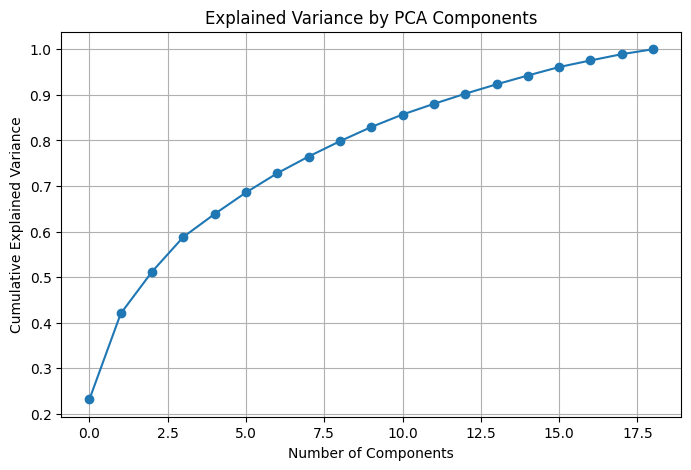

PC1: 0.2323 (0.2323 cumulative)
PC2: 0.1881 (0.4203 cumulative)
PC3: 0.0918 (0.5121 cumulative)
PC4: 0.0762 (0.5883 cumulative)
PC5: 0.0504 (0.6387 cumulative)
PC6: 0.0471 (0.6858 cumulative)
PC7: 0.0423 (0.7281 cumulative)
PC8: 0.0366 (0.7647 cumulative)
PC9: 0.0335 (0.7982 cumulative)
PC10: 0.0311 (0.8293 cumulative)
PC11: 0.0274 (0.8568 cumulative)
PC12: 0.0234 (0.8802 cumulative)
PC13: 0.0222 (0.9024 cumulative)
PC14: 0.0206 (0.9230 cumulative)
PC15: 0.0194 (0.9424 cumulative)
PC16: 0.0186 (0.9610 cumulative)
PC17: 0.0144 (0.9753 cumulative)
PC18: 0.0138 (0.9891 cumulative)
PC19: 0.0109 (1.0000 cumulative)

PCA Loadings:
      customer_gender  kids_home  teens_home  number_complaints  distinct_stores_visited  lifetime_spend_groceries  lifetime_spend_electronics  typical_hour  lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  lifetime_spend_alcohol_drinks  lifetime_spend_meat  lifetime_spend_fish  lifetime_spend_hygiene  lifetime_spend_videogames  lifetime_spend_petfood  

In [76]:
# PCA Analysis
# fit PCA
pca = PCA()
pca.fit(customer_info)

# explained variance ratio
explained_variance = pca.explained_variance_ratio_

# plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# print explained variance
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({np.cumsum(explained_variance)[i]:.4f} cumulative)")

# get loadings
loadings = pca.components_

# create loadings dataframe for easier interpretation
loadings_df = pd.DataFrame(loadings, columns=customer_info.columns, 
                            index=[f'PC{i+1}' for i in range(loadings.shape[0])])
print("\nPCA Loadings:")
print(loadings_df)


To assess which features are most important, we used the PCA loadings, which measure how strongly each original feature contributes to each principal component. Since some components explain more variance than others, we first squared the loadings (to focus on their strength regardless of sign), then multiplied them by the proportion of variance each component explains. Finally, we summed these values across all components. This gives an overall score showing how much each feature contributes to the total variability in the dataset.

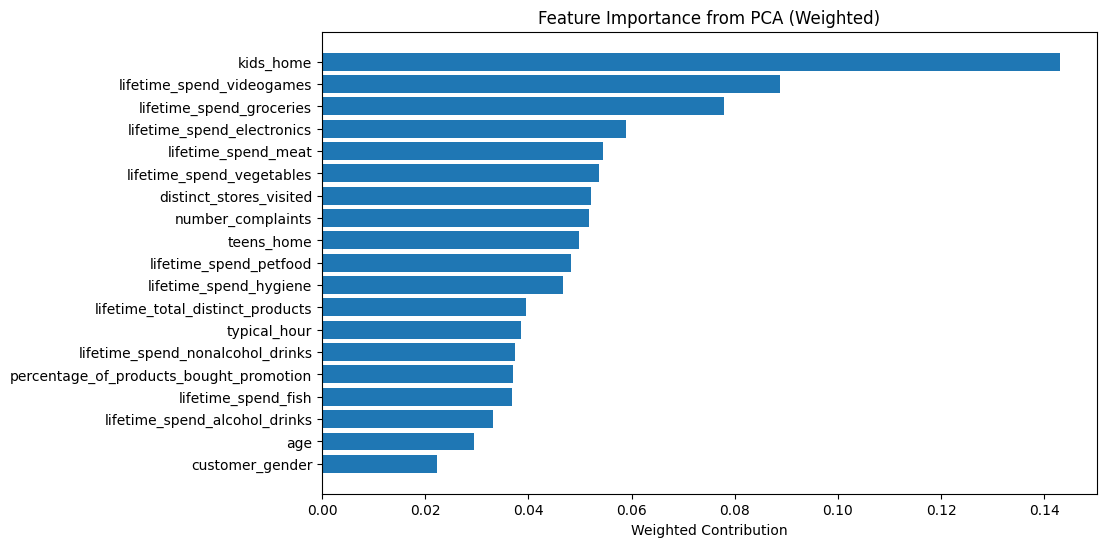

In [77]:
# after fitting PCA
loadings = pca.components_

# square loadings
squared_loadings = loadings**2

# multiply each squared loading by variance explained
weighted_contributions = squared_loadings * explained_variance[:, np.newaxis] # newaxis to convert the vector to a column vector

# sum over components to get total weighted contribution per feature
feature_importance = weighted_contributions.sum(axis=0)

# build dataframe
importance_df = pd.DataFrame({
    'Feature': customer_info.columns,
    'Weighted Contribution': feature_importance
}).sort_values(by='Weighted Contribution', ascending=False)

# plot the importance df
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Weighted Contribution'])
plt.xlabel('Weighted Contribution')
plt.title('Feature Importance from PCA (Weighted)')
plt.gca().invert_yaxis()
plt.show()

**PCA Analysis and Feature Retention Decision**

To assess potential redundancy and feature importance within the customer_info dataset, we applied Principal Component Analysis (PCA). The goal was to evaluate whether some features could be removed prior to clustering, while preserving as much relevant information as possible.

The cumulative explained variance plot shows that the first principal component (PC1) explains approximately 23% of the total variance, with diminishing contributions from subsequent components. In total, 10 components are required to explain roughly 82% of the variance, and all 19 components are necessary to reach 100% of explained variance. This indicates that the variance is relatively spread across many components, suggesting no overwhelming dominance of a small subset of features.

The loadings matrix further confirms that multiple features contribute significantly to different principal components. While certain variables such as kids_home, lifetime_spend_videogames, lifetime_spend_groceries, and lifetime_spend_electronics show higher weighted contributions, the remaining features also provide relevant information. Importantly, no feature shows an extremely low or negligible contribution that would justify its removal based solely on PCA results.

As a result, we conclude that all features contribute valuable information for characterizing customer profiles. Therefore, we will retain all variables for the clustering phase, ensuring that the full multidimensional structure of the data is preserved to capture potentially meaningful customer segments.

## STUFF TO DO ##

- We have duplicate rows on customer_basket

- Regarding the customer_basket dataset, when the same items are bought in two different instances, these are attributed different invoices. Thus we cannot make invoice_id our index column

- 32% of customers have a missing value at loyalty_card_number, meaning they probably don't have one.

- percentage_of_products_bought_promotion is a percentage, yet has negative values (DONE)

- Permanently drop the **customer_name**, **loyalty_card_number** and the **year_first_transaction** columns, as they're either irrelevant, or correlated with other variables

1. Import and preview Datasets (DONE)

2. Feature Selection (Part 1) (DONE)
- We will add and then remove columns 
- We will evaluate whether highly correlated variables will be kept 
- label encoding for the **customer_gender** variable 

3. Univariate Outlier Detection

4. Scaling (DONE)

5. Data Cleaning (DONE)
- Duplicates in customer_basket will not be deleted
- Missing values on customer_info

6. Multivariate Outlier Detection (DONE)
- DBSCAN

7. Feature Selection (Part 2) (DONE)
- PCA

8. Data exportation